Transition matrix (rows sum to 1):
[[0.98708227 0.01291773]
 [0.04166358 0.95833642]]
Model converged: True
Converged in 40 iterations (tol = 0.01 )
State means: [ 0.00071555 -0.00128752]
State stds:  [0.00636463 0.0172233 ]
Bull state: 0, Bear state: 1


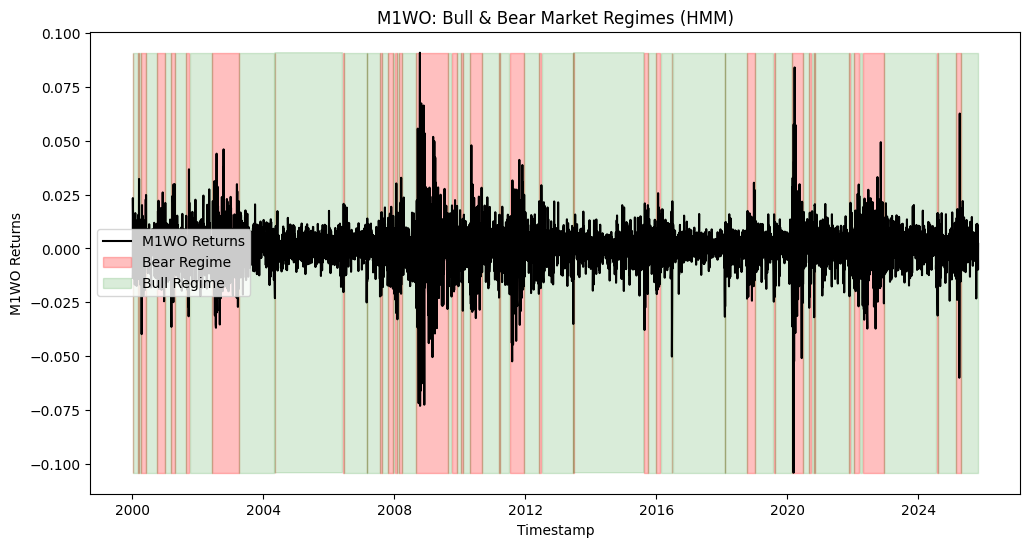

In [6]:
import pandas as pd
import numpy as np
import os, sys
sys.path.insert(0, os.path.abspath('../..'))
import source.data_handling.data_preparation as dp
import source.trading_strategies.trading_strategy as tsh
import source.plot_functions.plots_trading_strategies as plot_ts
import numpy as np
import pandas as pd
df = dp.create_classification_data(quiet=False)
df["Rfree"] = 0

In [7]:
pred_df = pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_logit.csv", index_col=0, parse_dates=True)
bt = tsh.backtest_paper_regime_switch(
    pred_df,
    price_col="M1WO_O",
    regime_col="y_pred",
    ts_col="timestamp",
    bear_label=0,
)
summary = tsh.compare_regime_strategies(bt, periods_per_year=252, gamma=5.0, benchmark="BuyHoldEq")
print(summary)

             TotalReturn      CAGR    AnnVol    Sharpe  MaxDrawdown  \
Strategy                                                              
Strategy        1.229178  0.050129  0.117138  0.476470    -0.292757   
BuyHoldEq       4.025733  0.103532  0.148473  0.738206    -0.340332   
BuyHoldRF       0.000000  0.000000  0.000000       NaN     0.000000   
Static50_50     1.346223  0.053413  0.074237  0.738206    -0.183277   

             AnnUtility  Δu vs BuyHoldEq  Δu vs HA  Δu vs 50%  Δu vs 100%  
Strategy                                                                   
Strategy       0.021509        -0.032984       NaN  -0.019515   -0.032984  
BuyHoldEq      0.054493         0.000000       NaN        NaN         NaN  
BuyHoldRF      0.000000        -0.054493       NaN        NaN         NaN  
Static50_50    0.041024        -0.013469       NaN        NaN         NaN  


/var/folders/q9/d545ygdx5rj6lg_00gpykppw0000gn/T/ipykernel_35816/2869902700.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pred_df = pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_logit.csv", index_col=0, parse_dates=True)


In [8]:
pred_df = pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_rf.csv", index_col=0, parse_dates=True)
bt = tsh.backtest_paper_regime_switch(
    pred_df,
    price_col="M1WO_O",
    regime_col="y_pred",
    ts_col="timestamp",
    bear_label=0,
)
summary = tsh.compare_regime_strategies(bt, periods_per_year=252, gamma=5.0, benchmark="BuyHoldEq")
print(summary)

             TotalReturn      CAGR    AnnVol    Sharpe  MaxDrawdown  \
Strategy                                                              
Strategy        0.908724  0.040232  0.112397  0.407431    -0.314708   
BuyHoldEq       4.025733  0.103532  0.148473  0.738206    -0.340332   
BuyHoldRF       0.000000  0.000000  0.000000       NaN     0.000000   
Static50_50     1.346223  0.053413  0.074237  0.738206    -0.183277   

             AnnUtility  Δu vs BuyHoldEq  Δu vs HA  Δu vs 50%  Δu vs 100%  
Strategy                                                                   
Strategy       0.014211        -0.040282       NaN  -0.026813   -0.040282  
BuyHoldEq      0.054493         0.000000       NaN        NaN         NaN  
BuyHoldRF      0.000000        -0.054493       NaN        NaN         NaN  
Static50_50    0.041024        -0.013469       NaN        NaN         NaN  


/var/folders/q9/d545ygdx5rj6lg_00gpykppw0000gn/T/ipykernel_35816/4063035673.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pred_df = pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_rf.csv", index_col=0, parse_dates=True)


/var/folders/q9/d545ygdx5rj6lg_00gpykppw0000gn/T/ipykernel_35816/2784377802.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  "Logit": pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_logit.csv", index_col=0, parse_dates=True),   # must have columns timestamp + y_pred
/var/folders/q9/d545ygdx5rj6lg_00gpykppw0000gn/T/ipykernel_35816/2784377802.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  "RF": pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_rf.csv", index_col=0, parse_dates=True),
/var/folders/q9/d545ygdx5rj6lg_00gpykppw0000gn/T/ipykernel_35816/2784377802.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensu

Logit total return (plotted sample): 125.45%
RF total return (plotted sample): 163.30%
TabPFN total return (plotted sample): 294.65%
Mantis_RF_head total return (plotted sample): 381.57%
mantis_head total return (plotted sample): 390.19%
Buy & Hold Equity (W100) total return (plotted sample): 402.57%


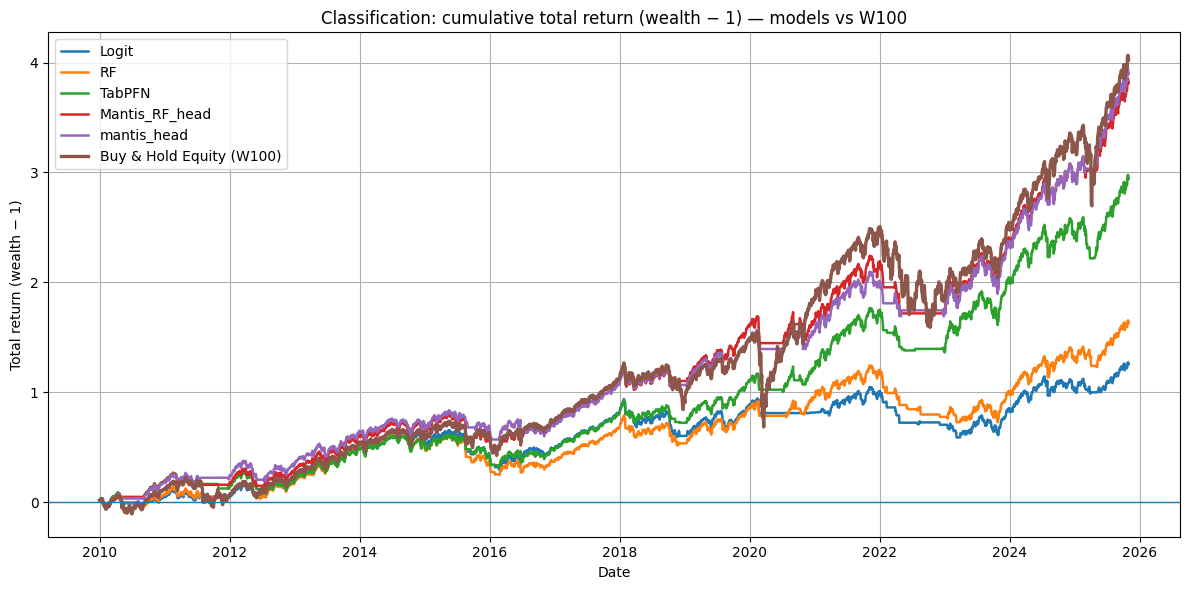

In [9]:

pred_dfs = {
    "Logit": pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_logit.csv", index_col=0, parse_dates=True),   # must have columns timestamp + y_pred
    "RF": pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_rf.csv", index_col=0, parse_dates=True),
    "TabPFN": pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_tabpfn25.csv", index_col=0, parse_dates=True),
    "Mantis_RF_head": pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_mantis_rf_head.csv", index_col=0, parse_dates=True),
    "mantis_head": pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_mantis_head.csv", index_col=0, parse_dates=True)

}

df_mkt = df[["timestamp", "M1WO_O", "Rfree"]].copy()
plot_ts.plot_total_return_models_vs_w100(
    pred_dfs,
    df_mkt,
    price_col="M1WO_O",
    rf_col="Rfree",
    regime_col="y_pred",
    bear_label=1,
    tc_bps=0.0,
    title="Classification: cumulative total return (wealth − 1) — models vs W100",
)

In [10]:
pred_df = pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_rf.csv", index_col=0, parse_dates=True)
bt = tsh.backtest_paper_regime_switch(
    pred_df,
    price_col="M1WO_O",
    regime_col="y_pred",
    ts_col="timestamp",
    bear_label=0,
)
summary = tsh.compare_regime_strategies(bt, periods_per_year=252, gamma=5.0, benchmark="BuyHoldEq")
print(summary)

             TotalReturn      CAGR    AnnVol    Sharpe  MaxDrawdown  \
Strategy                                                              
Strategy        0.908724  0.040232  0.112397  0.407431    -0.314708   
BuyHoldEq       4.025733  0.103532  0.148473  0.738206    -0.340332   
BuyHoldRF       0.000000  0.000000  0.000000       NaN     0.000000   
Static50_50     1.346223  0.053413  0.074237  0.738206    -0.183277   

             AnnUtility  Δu vs BuyHoldEq  Δu vs HA  Δu vs 50%  Δu vs 100%  
Strategy                                                                   
Strategy       0.014211        -0.040282       NaN  -0.026813   -0.040282  
BuyHoldEq      0.054493         0.000000       NaN        NaN         NaN  
BuyHoldRF      0.000000        -0.054493       NaN        NaN         NaN  
Static50_50    0.041024        -0.013469       NaN        NaN         NaN  


/var/folders/q9/d545ygdx5rj6lg_00gpykppw0000gn/T/ipykernel_35816/4063035673.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pred_df = pd.read_csv("../../Data/ModelData/Classification/pred_df_loop_rf.csv", index_col=0, parse_dates=True)


In [11]:
for i in pred_dfs:
    print(f"Backtesting strategy for {i}")
    bt = tsh.backtest_paper_regime_switch(
        pred_dfs[i],
        price_col="M1WO_O",
        regime_col="y_pred",
        ts_col="timestamp",
        bear_label=1,
    )
    summary = tsh.compare_regime_strategies(bt, periods_per_year=252, gamma=5.0, benchmark="BuyHoldEq")
    print(summary)

Backtesting strategy for Logit
             TotalReturn      CAGR    AnnVol    Sharpe  MaxDrawdown  \
Strategy                                                              
Strategy        1.254523  0.050854  0.091360  0.588776    -0.223939   
BuyHoldEq       4.025733  0.103532  0.148473  0.738206    -0.340332   
BuyHoldRF       0.000000  0.000000  0.000000       NaN     0.000000   
Static50_50     1.346223  0.053413  0.074237  0.738206    -0.183277   

             AnnUtility  Δu vs BuyHoldEq  Δu vs HA  Δu vs 50%  Δu vs 100%  
Strategy                                                                   
Strategy       0.032924        -0.021569       NaN    -0.0081   -0.021569  
BuyHoldEq      0.054493         0.000000       NaN        NaN         NaN  
BuyHoldRF      0.000000        -0.054493       NaN        NaN         NaN  
Static50_50    0.041024        -0.013469       NaN        NaN         NaN  
Backtesting strategy for RF
             TotalReturn      CAGR    AnnVol    Sharpe  Ma